In [ ]:
#Load and clean data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Step 1: Load and Inspect the Data

In [ ]:
ecom = pd.read_csv('/content/ecommerce_dataset.csv')

##Use Case:
**Track 90-day retention of new users from a mock e-commerce dataset. Identify drop-off patterns, segment by acquisition channel, and calculate cohort-level LTV.**

In [ ]:
ecom.head()

,user_id,signup_date,purchase_date,amount,channel,product_category
0,1,2024-02-21,2024-03-13 08:25:06.350735,80.00,direct,books
1,1,2024-02-21,2024-03-03 21:21:33.775103,179.44,direct,electronics
2,4,2024-03-15,2024-03-22 23:22:17.723858,19.41,email,books
3,4,2024-03-15,2024-03-21 07:02:37.763396,109.70,email,home_garden
4,4,2024-03-15,2024-03-22 11:58:49.461883,22.65,email,books


In [ ]:
#checking for any missing values
ecom.isnull().sum()
#no missing values

,0
user_id,0
signup_date,0
purchase_date,0
amount,0
channel,0
product_category,0


In [ ]:
#Looking at underlying datatypes; whether type conversion is needed
ecom.info()
ecom.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5365 entries, 0 to 5364
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   user_id           5365 non-null   int64  
 1   signup_date       5365 non-null   object 
 2   purchase_date     5365 non-null   object 
 3   amount            5365 non-null   float64
 4   channel           5365 non-null   object 
 5   product_category  5365 non-null   object 
dtypes: float64(1), int64(1), object(4)
memory usage: 251.6+ KB


,user_id,amount
count,5365.000000,5365.000000
mean,2485.997950,108.137387
std,1454.674161,125.014979
min,1.000000,5.000000
25%,1202.000000,35.950000
50%,2523.000000,63.820000
75%,3726.000000,121.720000
max,4997.000000,1126.660000


### Converting dates into datetime datatype

In [ ]:
#change signup_date and purchase_date to datetime
ecom['signup_date'] = pd.to_datetime(ecom['signup_date'])
ecom['purchase_date'] = pd.to_datetime(ecom['purchase_date'])

### Step 2: Assign Cohorts

In [ ]:
# create month-year cohorts : signup_date --> Month-Year
#logic - cohort = month-year eg ecom['cohort'] = extract month-year from ecom['signup_date']
ecom['cohort'] = ecom['signup_date'].dt.strftime('%m-%Y')

In [ ]:
# Calculate week_since_signup
ecom['week_since_signup'] = (ecom['purchase_date']
                             - ecom['signup_date']).dt.days // 7

In [ ]:
# Build Retention Matrix
retention_matrix = ecom.pivot_table(index = 'cohort', columns =
                    'week_since_signup', values = 'user_id', aggfunc= 'count')
retention_matrix

week_since_signup,0,1,2,3,4,5,6,7,8,9,10,11,12
cohort,,,,,,,,,,,,,
01-2024,691.0,518.0,365.0,273.0,165.0,134.0,87.0,61.0,53.0,18.0,8.0,3.0,1.0
02-2024,645.0,477.0,329.0,216.0,128.0,88.0,42.0,17.0,1.0,NaN,NaN,NaN,NaN
03-2024,554.0,311.0,124.0,55.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Step 3: Calculate Metrics
1. Retention Rate
2. Total Revenue per cohort
3. Lifetime Value (LTV) per cohort

In [ ]:
# Calculate Retention %, Total Revenue, LTV per Cohort

#logic = week [1] numbers/ week [0] numbers,....
#divides each value by the first column, row-wise

retention_rate = retention_matrix.divide(retention_matrix.iloc[:,0], axis = 0)
retention_rate

week_since_signup,0,1,2,3,4,5,6,7,8,9,10,11,12
cohort,,,,,,,,,,,,,
01-2024,1.0,0.749638,0.528220,0.395080,0.238784,0.193922,0.125904,0.088278,0.07670,0.026049,0.011577,0.004342,0.001447
02-2024,1.0,0.739535,0.510078,0.334884,0.198450,0.136434,0.065116,0.026357,0.00155,NaN,NaN,NaN,NaN
03-2024,1.0,0.561372,0.223827,0.099278,0.001805,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Calculate total revenue by cohort

total_revenue_by_cohort = ecom.groupby(['cohort'])['amount'].sum()
total_revenue_by_cohort

,amount
cohort,
01-2024,258983.14
02-2024,201419.36
03-2024,119754.58


In [ ]:
# Lifetime Value per cohort
#LTV per Cohort = Total Revenue from Cohort / Number of Users in Cohort
LTV_per_cohort = total_revenue_by_cohort / retention_matrix.iloc[:,0]
LTV_per_cohort

,0
cohort,
01-2024,374.794703
02-2024,312.278078
03-2024,216.163502


In [ ]:
# Segment number of users by acquisition channel and cohort
retention_matrix_by_channel = ecom.pivot_table(index = ['channel','cohort'],
                              columns = 'week_since_signup', values = 'user_id', aggfunc='count')
retention_matrix_by_channel

week_since_signup        0      1     2     3     4     5     6     7     8   \
channel      cohort                                                            
direct       01-2024  107.0   75.0  74.0  41.0  25.0  19.0  10.0   6.0   9.0   
             02-2024  115.0   78.0  62.0  40.0  18.0  18.0   6.0   3.0   NaN   
             03-2024  109.0   66.0  23.0  11.0   1.0   NaN   NaN   NaN   NaN   
email        01-2024  155.0  133.0  69.0  66.0  44.0  29.0  25.0  17.0  12.0   
             02-2024  152.0  112.0  74.0  54.0  23.0  21.0   9.0   2.0   1.0   
             03-2024  149.0   72.0  31.0  17.0   NaN   NaN   NaN   NaN   NaN   
organic      01-2024  152.0  123.0  74.0  55.0  35.0  31.0  22.0  16.0  14.0   
             02-2024  159.0  114.0  89.0  47.0  32.0  22.0   9.0   5.0   NaN   
             03-2024  107.0   54.0  23.0   6.0   NaN   NaN   NaN   NaN   NaN   
paid_search  01-2024  151.0  117.0  75.0  57.0  36.0  33.0  17.0  15.0   8.0   
             02-2024  130.0   98.0  63.0  47.0  31.0  16.0  14.0   4.0   NaN   
             03-2024  128.0   78.0  29.0  13.0   NaN   NaN   NaN   NaN   NaN   
referral     01-2024   29.0   21.0  19.0  19.0   4.0   8.0   5.0   2.0   1.0   
             02-2024   19.0   17.0  12.0   6.0   7.0   2.0   1.0   3.0   NaN   
             03-2024   14.0   10.0   5.0   4.0   NaN   NaN   NaN   NaN   NaN   
social_media 01-2024   97.0   49.0  54.0  35.0  21.0  14.0   8.0   5.0   9.0   
             02-2024   70.0   58.0  29.0  22.0  17.0   9.0   3.0   NaN   NaN   
             03-2024   47.0   31.0  13.0   4.0   NaN   NaN   NaN   NaN   NaN   

week_since_signup      9    10   11   12  
channel      cohort                       
direct       01-2024  1.0  3.0  NaN  NaN  
             02-2024  NaN  NaN  NaN  NaN  
             03-2024  NaN  NaN  NaN  NaN  
email        01-2024  3.0  2.0  NaN  1.0  
             02-2024  NaN  NaN  NaN  NaN  
             03-2024  NaN  NaN  NaN  NaN  
organic      01-2024  8.0  1.0  1.0  NaN  
             02-2024  NaN  NaN  NaN  NaN  
             03-2024  NaN  NaN  NaN  NaN  
paid_search  01-2024  3.0  NaN  2.0  NaN  
             02-2024  NaN  NaN  NaN  NaN  
             03-2024  NaN  NaN  NaN  NaN  
referral     01-2024  1.0  NaN  NaN  NaN  
             02-2024  NaN  NaN  NaN  NaN  
             03-2024  NaN  NaN  NaN  NaN  
social_media 01-2024  2.0  2.0  NaN  NaN  
             02-2024  NaN  NaN  NaN  NaN  
             03-2024  NaN  NaN  NaN  NaN

In [ ]:
# Calculate cohort_retention_by_channel

retention_rate_by_channel = retention_matrix_by_channel.divide(
    retention_matrix_by_channel.iloc[:,0], axis = 0)
retention_rate_by_channel

week_since_signup      0         1         2         3         4         5   \
channel      cohort                                                           
direct       01-2024  1.0  0.700935  0.691589  0.383178  0.233645  0.177570   
             02-2024  1.0  0.678261  0.539130  0.347826  0.156522  0.156522   
             03-2024  1.0  0.605505  0.211009  0.100917  0.009174       NaN   
email        01-2024  1.0  0.858065  0.445161  0.425806  0.283871  0.187097   
             02-2024  1.0  0.736842  0.486842  0.355263  0.151316  0.138158   
             03-2024  1.0  0.483221  0.208054  0.114094       NaN       NaN   
organic      01-2024  1.0  0.809211  0.486842  0.361842  0.230263  0.203947   
             02-2024  1.0  0.716981  0.559748  0.295597  0.201258  0.138365   
             03-2024  1.0  0.504673  0.214953  0.056075       NaN       NaN   
paid_search  01-2024  1.0  0.774834  0.496689  0.377483  0.238411  0.218543   
             02-2024  1.0  0.753846  0.484615  0.361538  0.238462  0.123077   
             03-2024  1.0  0.609375  0.226562  0.101562       NaN       NaN   
referral     01-2024  1.0  0.724138  0.655172  0.655172  0.137931  0.275862   
             02-2024  1.0  0.894737  0.631579  0.315789  0.368421  0.105263   
             03-2024  1.0  0.714286  0.357143  0.285714       NaN       NaN   
social_media 01-2024  1.0  0.505155  0.556701  0.360825  0.216495  0.144330   
             02-2024  1.0  0.828571  0.414286  0.314286  0.242857  0.128571   
             03-2024  1.0  0.659574  0.276596  0.085106       NaN       NaN   

week_since_signup           6         7         8         9         10  \
channel      cohort                                                      
direct       01-2024  0.093458  0.056075  0.084112  0.009346  0.028037   
             02-2024  0.052174  0.026087       NaN       NaN       NaN   
             03-2024       NaN       NaN       NaN       NaN       NaN   
email        01-2024  0.161290  0.109677  0.077419  0.019355  0.012903   
             02-2024  0.059211  0.013158  0.006579       NaN       NaN   
             03-2024       NaN       NaN       NaN       NaN       NaN   
organic      01-2024  0.144737  0.105263  0.092105  0.052632  0.006579   
             02-2024  0.056604  0.031447       NaN       NaN       NaN   
             03-2024       NaN       NaN       NaN       NaN       NaN   
paid_search  01-2024  0.112583  0.099338  0.052980  0.019868       NaN   
             02-2024  0.107692  0.030769       NaN       NaN       NaN   
             03-2024       NaN       NaN       NaN       NaN       NaN   
referral     01-2024  0.172414  0.068966  0.034483  0.034483       NaN   
             02-2024  0.052632  0.157895       NaN       NaN       NaN   
             03-2024       NaN       NaN       NaN       NaN       NaN   
social_media 01-2024  0.082474  0.051546  0.092784  0.020619  0.020619   
             02-2024  0.042857       NaN       NaN       NaN       NaN   
             03-2024       NaN       NaN       NaN       NaN       NaN   

week_since_signup           11        12  
channel      cohort                       
direct       01-2024       NaN       NaN  
             02-2024       NaN       NaN  
             03-2024       NaN       NaN  
email        01-2024       NaN  0.006452  
             02-2024       NaN       NaN  
             03-2024       NaN       NaN  
organic      01-2024  0.006579       NaN  
             02-2024       NaN       NaN  
             03-2024       NaN       NaN  
paid_search  01-2024  0.013245       NaN  
             02-2024       NaN       NaN  
             03-2024       NaN       NaN  
referral     01-2024       NaN       NaN  
             02-2024       NaN       NaN  
             03-2024       NaN       NaN  
social_media 01-2024       NaN       NaN  
             02-2024       NaN       NaN  
             03-2024       NaN       NaN

In [ ]:
# calculate total revenue by cohort for each channel
# sum amount for each cohort
total_revenue_by_cohort_channel = ecom.groupby(['cohort','channel'])['amount'].sum()
total_revenue_by_cohort_channel

cohort   channel     
01-2024  direct          39497.92
         email           60554.79
         organic         62329.58
         paid_search     51600.65
         referral        14655.88
         social_media    30344.32
02-2024  direct          36406.74
         email           47951.65
         organic         48867.53
         paid_search     40084.43
         referral         6739.56
         social_media    21369.45
03-2024  direct          23739.41
         email           28280.55
         organic         23739.60
         paid_search     28798.89
         referral         3913.35
         social_media    11282.78
Name: amount, dtype: float64

### Step 4: Visualizations

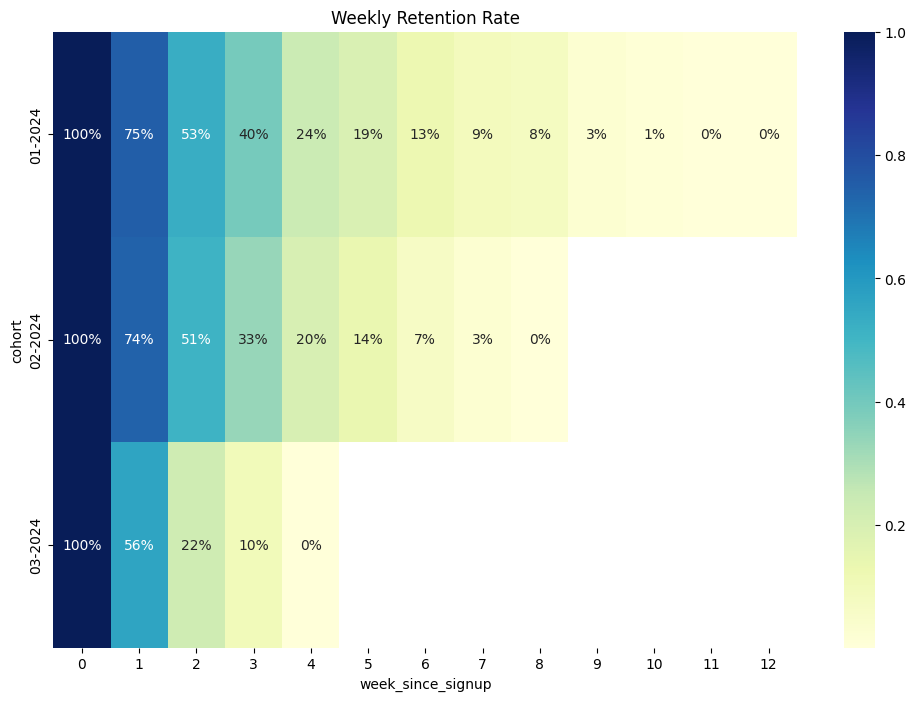

In [ ]:
# Heatmap showing weekly retention rate per cohort
plt.figure(figsize = (12,8))
sns.heatmap(retention_rate, cmap = 'YlGnBu', annot = True, fmt = '.0%')
plt.title('Weekly Retention Rate')
plt.show()

#### Insights from Heatmap
- **Steep drop-off** occurs across all cohorts between Week 0 → Week 1 and Week 1 → Week 2:
    - Jan: 691 → 518 → 365 (25% drop in W1, 30% in W2)
    - Feb: 645 → 477 → 329 (26% drop in W1, 31% in W2)
    - Mar: 554 → 311 → 124 (44% drop in W1, 60% in W2)
- March Cohort performs weakest:
    - Retention plunges after Week 1 with 0% active users by Week 4
    - Indicates issues with onboarding, early experience or changes in acquisition quality

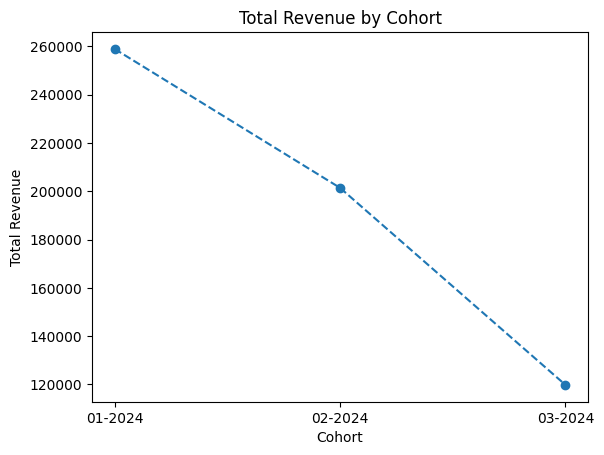

<Figure size 1200x800 with 0 Axes>

In [ ]:
#line plot showcasing total revenue by cohort
plt.plot(total_revenue_by_cohort.index, total_revenue_by_cohort.values,
         marker = 'o', linestyle = 'dashed')
plt.title('Total Revenue by Cohort')
plt.xlabel('Cohort')
plt.ylabel('Total Revenue')
plt.figure(figsize=(12,8))
plt.show()

### Insights from the line plot

- Total Revenue per cohort
  - Jan Cohort is the strongest performing in terms of revenue
  - 22% decline (from jan) in revenue in the Feb Cohort
  - 40% decline from Feb in Jan Cohort

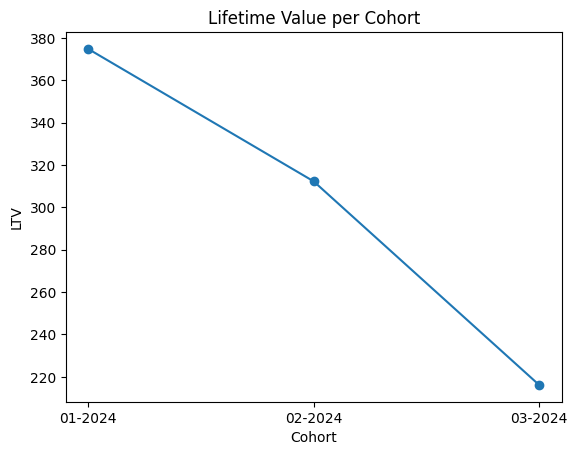

In [ ]:
#Line plot showing LTV per cohort
plt.plot(LTV_per_cohort.index, LTV_per_cohort.values, marker = 'o')
plt.title('Lifetime Value per Cohort')
plt.xlabel('Cohort')
plt.ylabel('LTV')
plt.show()

- LTV per cohort
  - 01-2024 cohort: \$374.79 per customer
  - 02-2024 cohort: \$312.28 per customer (17% lower)
  - 03-2024 cohort: \$216.16 per customer (31% lower than February)

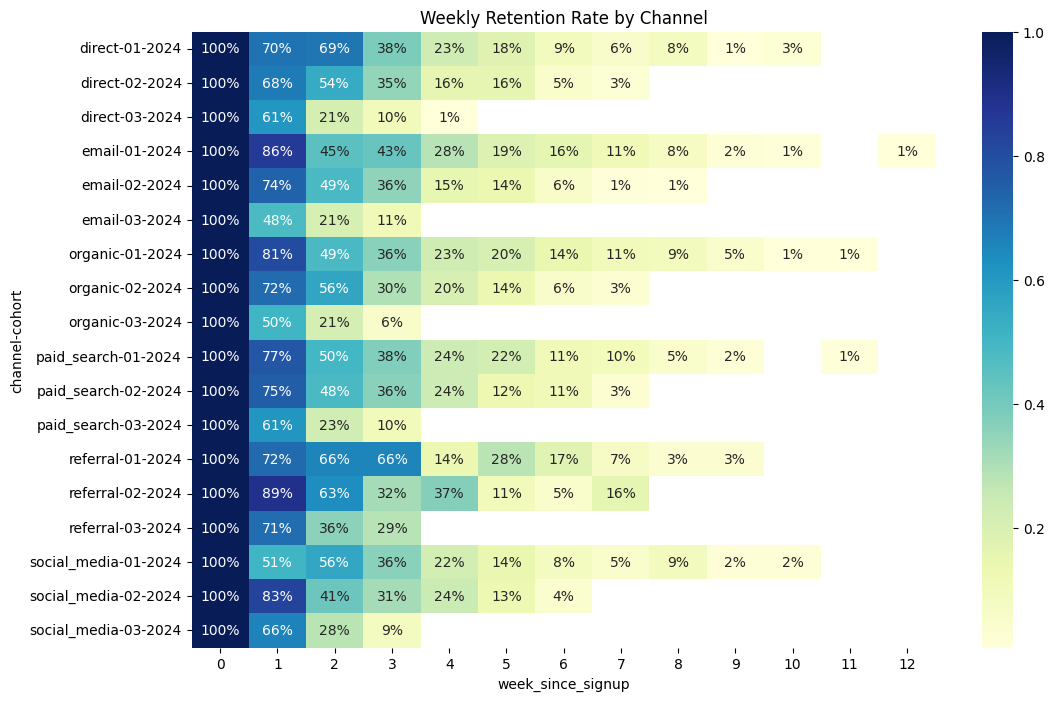

In [ ]:
# Heatmap showing cohort retention rate broken by channel

plt.figure(figsize = (12,8))
sns.heatmap(retention_rate_by_channel, cmap = 'YlGnBu', annot = True, fmt = '.0%')
plt.title('Weekly Retention Rate by Channel')
plt.show()


### Insights from retention_rate per cohort by acquisition channels

1. Email - Clear winner with deepest blue retention

  - 01-2024: 86% week 1, maintains 16% at week 6
  - Consistently strongest long-term retention


2. Organic - Second best overall

- 01-2024: 81% week 1, solid retention curve
- High-quality, intent-driven users


3. Paid Search - Moderate but consistent

  - 77% week 1 retention in January
  - Decent long-term performance


4.Referral - Good early retention, volatile later

  - Strong week 1-3 performance
  - Inconsistent long-term patterns


5. Direct - Declining performance

  - Started strong in January but deteriorating


6. Social Media - Consistently worst performer

  - Lowest retention across all time periods
  - Poor long-term value


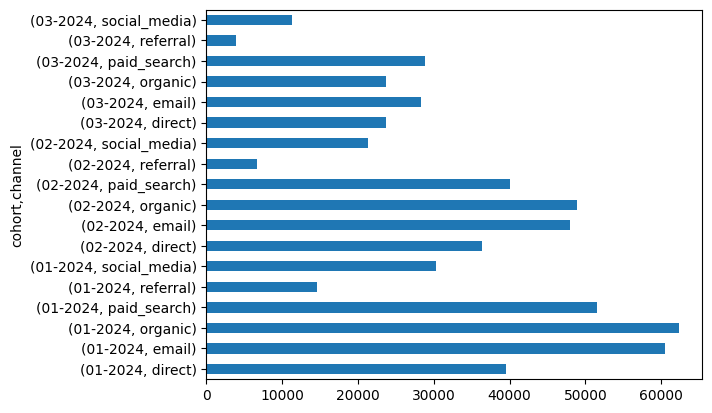

In [64]:
#bar chart: total revenue by channels and cohort
total_revenue_by_cohort_channel.plot(kind = 'barh');

# 📌 Key Takeaways:
1. Jan is the best performing cohort across all channels

  This suggests:

  - Seasonal factors (New Year motivation, tax refunds)
  - Product-market fit was stronger then
  - Marketing messaging or targeting changed after January

2. Strategic Actions:
  - Investigate what changed after Jan 2024 (this is the biggest opportunity)
  - Pause or reduce social media spend (Poor Performance/ROI)
  - Double down on email marketing